In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
import os
import sys
from chimera import Chimera

sns.set(style='ticks', context='notebook', font_scale=1.2)

In [2]:
# load experimental data
data = pd.read_csv('big1.csv')
# data = data[data.WL != 0]
# data.reset_index(drop=True, inplace=True)
data.loc[:, 'WL_transformed'] = np.abs(data.loc[:, 'WL'] - 540)  # target is 540 +/- 2
data.loc[:, 'R_transformed'] = np.abs(data.loc[:, 'R'] - 6.5)  # target is 3.5 +- 0.5
data_post_num = 0
data_post = data[data_post_num:]
data_post

,#,HAuCl4,PVP,Glucose,NaOH,Time,A450,WL,FWHM,R,std,WL_transformed,R_transformed
0,1,19.36,20.00,9.78,19.94,3.09,0.16836,520.5,118,6.42,0.00168 0.5 0. 0.17,19.5,0.08
1,2,9.86,7.80,5.33,11.35,8.56,0.06708,525.0,117,5.64,0.003845 0. 1. 0.015,15.0,0.86
2,3,9.63,13.45,4.30,8.72,9.91,0.02293,522.0,119,4.74,9.10e-04 1.00e+00 3.00e+00 7.55e-01,18.0,1.76
3,4,12.24,19.52,19.21,19.79,5.68,0.11098,526.5,120,5.36,1.26e-03 5.00e-01 2.00e+00 4.65e-01,13.5,1.14
4,5,11.48,18.98,19.88,19.14,6.06,0.10343,529.0,129,4.40,0.00464 1. 1. 0.195,11.0,2.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,13.53,12.74,15.37,7.59,7.36,0.04290,540.5,149,2.52,2.005e-03 5.000e-01 3.000e+00 4.500e-02,0.5,3.98
96,97,16.01,10.73,16.57,19.90,4.84,0.10600,544.5,142,2.37,3.05e-04 5.00e-01 2.00e+00 5.00e-02,4.5,4.13
97,98,12.48,9.39,15.91,14.57,2.83,0.08470,548.0,152,2.02,0.00307 0. 2. 0.035,8.0,4.48
98,99,14.95,10.28,17.62,20.00,4.57,0.10887,548.0,142,2.20,9.9e-04 1.0e+00 2.0e+00 2.0e-02,8.0,4.30


## Process data to get relevant info

In [3]:
# define multi-objective preferences
chimera = Chimera(tolerances=[2, 0.4, 0.0], absolutes=[True, False, False], goals=['min', 'min', 'max'])
# chimera = Chimera(tolerances=[0.5, 0.4, 0.0], absolutes=[True, False, False], goals=['min', 'min', 'max'])

# Get index of best solution at each experimental iteration
best_indices = []
for i in data_post.index:
    # consider objectives for experiments up to i
    objectives = data.loc[:i, ['WL_transformed', 'FWHM', 'A450']]
#     objectives = data.loc[:i, ['R_transformed', 'FWHM', 'A450']]
    # scalarize objectives
    scalarized = chimera.scalarize(objectives)
    # save index of best up to i
    best_idx = np.argmin(scalarized[data_post_num:])
    best_indices.append(best_idx + data_post_num)
    
# get history of objectives for best solution
print (data_post.loc[best_indices[-1]])
obj_1 = [data.loc[:i, 'WL_transformed'].to_numpy()[i - data_post_num] for i in best_indices]
# obj_1 = [data_post.loc[:i, 'R_transformed'].to_numpy()[i - data_post_num] for i in best_indices]
obj_2 = [data_post.loc[:i, 'FWHM'].to_numpy()[i - data_post_num] for i in best_indices]
obj_3 = [data_post.loc[:i, 'A450'].to_numpy()[i - data_post_num] for i in best_indices]
# print (best_indices)

#                                                      73
HAuCl4                                              15.43
PVP                                                 10.69
Glucose                                             16.88
NaOH                                                19.45
Time                                                 4.83
A450                                              0.11582
WL                                                    541
FWHM                                                  130
R                                                    3.18
std               3.635e-03 0.000e+00 4.000e+00 1.300e-01
WL_transformed                                          1
R_transformed                                        3.32
Name: 72, dtype: object


In [4]:
# get dynamic/relative 0.4 threshold for FWHM
min_fwhm_list = []
max_fwhm_list = []
thr_fwhm_list = []

for i in data_post.index:
    indices_met_WL = np.where(data.loc[:i, 'WL_transformed'] <= 2.0)[0]
#     indices_met_WL = np.where(data.loc[:i, 'R_transformed'] <= 0.5)[0]
#     print (i, indices_met_WL)
    if indices_met_WL.size != 0:
        min_fwhm = data.loc[indices_met_WL, 'FWHM'].min()
        sorted_fwhm = np.unique(data.loc[indices_met_WL, 'FWHM'])
        thr_fwhm = sorted_fwhm[int(len(sorted_fwhm) * 0.4)]
        max_fwhm = data.loc[indices_met_WL, 'FWHM'].max()
#         thr_fwhm = min_fwhm + (max_fwhm - min_fwhm) * 0.4
    else:
        min_fwhm = max_fwhm = thr_fwhm = obj_2[i]
    min_fwhm_list.append(min_fwhm)
    max_fwhm_list.append(max_fwhm)
    thr_fwhm_list.append(thr_fwhm)   


# get final/last 0.4 threshold for FWHM
# min_fwhm = data.loc[:, 'FWHM'].min()
# max_fwhm = data.loc[:, 'FWHM'].max()
# thres_fwhm = data.loc[:, 'FWHM'].min() + (max_fwhm - min_fwhm) * 0.4
print (thr_fwhm_list[-1])

138


## Three 1D plots

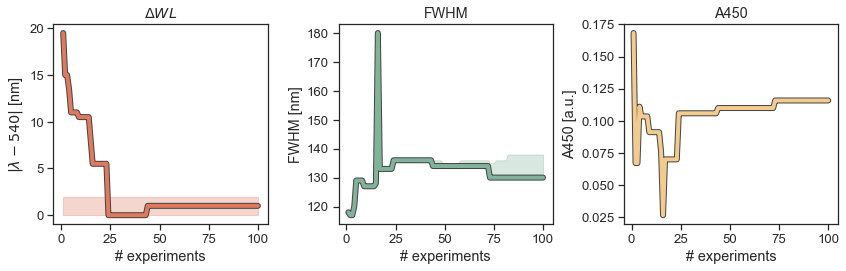

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(12,4))
# fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(ncols=2, nrows=2, figsize=(8,8))

experiment_nums = range(data_post_num + 1, len(data) + 1, 1)  # for x-axis

assert len(min_fwhm_list) == len(obj_2) == len(experiment_nums)

# colors
c1 = '#e07a5f'
c2 = '#81b29a'
c3 = '#f2cc8f'

# -----------
# plot traces
# -----------
ax1.plot(experiment_nums, obj_1, color='#444444', linewidth=6)
ax1.plot(experiment_nums, obj_1, color=c1, linewidth=4)

ax2.plot(experiment_nums, obj_2, color='#444444', linewidth=6)
ax2.plot(experiment_nums, obj_2, color=c2, linewidth=4)

ax3.plot(experiment_nums, obj_3, color='#444444', linewidth=6)
ax3.plot(experiment_nums, obj_3, color=c3, linewidth=4)

# ax4.plot(experiment_nums, scalarized[data_post_num:], color='#444444', linewidth=6)

# -------------------------------------
# plot target region for the objectives 
# -------------------------------------
ax1.fill_between(x=experiment_nums, y1=0.0, y2=2.0, color=c1, alpha=0.3)
# ax1.fill_between(x=experiment_nums, y1=0.0, y2=0.5, color=c1, alpha=0.3)

#ax2.fill_between(x=experiment_nums, y1=min_fwhm, y2=thr_fwhm, color=c2, alpha=0.3)  # simpler
ax2.fill_between(x=experiment_nums, y1=min_fwhm_list, y2=thr_fwhm_list, color=c2, alpha=0.3)  # perhaps more accurate


# titles and labels
for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('# experiments')
    
ax1.set_title('$\Delta WL$')
# ax1.set_title('$\Delta R$')
ax2.set_title('FWHM')
ax3.set_title('A450')

ax1.set_ylabel('$|\lambda - 540|$ [nm]')
# ax1.set_ylabel('$|R - 6.5|$')
ax2.set_ylabel('FWHM [nm]')
ax3.set_ylabel('A450 [a.u.]')

# ax1.set_ylim([0.,2.])
# ax2.set_ylim([100.,200.])
# ax3.set_ylim([0.1,0.125])
    
plt.tight_layout()
fig.savefig("objectives_plot.pdf", bbox_inches='tight')

## 3D plot

In [6]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

def cuboid_data(pos, size=(1,1,1)):
    # code taken from
    # https://stackoverflow.com/a/35978146/4124317
    # suppose axis direction: x: to left; y: to inside; z: to upper
    # get the (left, outside, bottom) point
    o = [a - b / 2 for a, b in zip(pos, size)]
    # get the length, width, and height
    l, w, h = size
    x = [[o[0], o[0] + l, o[0] + l, o[0], o[0]],  
         [o[0], o[0] + l, o[0] + l, o[0], o[0]],  
         [o[0], o[0] + l, o[0] + l, o[0], o[0]],  
         [o[0], o[0] + l, o[0] + l, o[0], o[0]]]  
    y = [[o[1], o[1], o[1] + w, o[1] + w, o[1]],  
         [o[1], o[1], o[1] + w, o[1] + w, o[1]],  
         [o[1], o[1], o[1], o[1], o[1]],          
         [o[1] + w, o[1] + w, o[1] + w, o[1] + w, o[1] + w]]   
    z = [[o[2], o[2], o[2], o[2], o[2]],                       
         [o[2] + h, o[2] + h, o[2] + h, o[2] + h, o[2] + h],   
         [o[2], o[2], o[2] + h, o[2] + h, o[2]],               
         [o[2], o[2], o[2] + h, o[2] + h, o[2]]]               
    return np.array(x), np.array(y), np.array(z)

# def plotCubeAt(ax=None, pos=(0,0,0), size=(1,1,1)):
#     # Plotting a cube element at position pos
#     if ax !=None:
        

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll

def multicolored_lines():
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    """

    x = np.linspace(0, 4. * np.pi, 100)
    y = np.sin(x)
    fig, ax = plt.subplots()
    lc = colorline(x, y, cmap='hsv')
    plt.colorbar(lc)
    plt.xlim(x.min(), x.max())
    plt.ylim(-1.0, 1.0)
    plt.show()

def colorline(
        x, y, z=None, cmap='copper', norm=plt.Normalize(0.0, 1.0),
        linewidth=3, alpha=1.0):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    # to check for numerical input -- this is a hack
    if not hasattr(z, "__iter__"):
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha)

    ax = plt.gca()
    ax.add_collection(lc)

    return lc

def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

In [43]:
%%capture test
filenames = []

# obj_1 = data_post.loc[:, 'WL_transformed']
# obj_2 = data_post.loc[:, 'FWHM']
# obj_3 = data_post.loc[:, 'A450']

for i in range(len(obj_1)):
    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot(projection='3d')
    ax.set_xlim(0, 20)
    ax.set_ylim(120, 180)
    ax.set_zlim(0.04, 0.16)
    cmap = plt.cm.magma_r(np.linspace(0, 1, len(obj_1)))
    
    ax.plot(obj_1[:i + 1], obj_2[:i + 1], obj_3[:i + 1], linewidth=4, color='#444444')
    ax.plot(obj_1[:i + 1], obj_2[:i + 1], obj_3[:i + 1], linewidth=3, color='#f2cc8f')
    sc = ax.scatter(obj_1[:i + 1], obj_2[:i + 1], obj_3[:i + 1], s=100, c=cmap[:i + 1], edgecolor='#444444', linewidth=2)
    

    #fig.colorbar(sc, shrink=0.5, pad=0.15)
    # Add colorbar
    fig.subplots_adjust(right=1)
    cbar_ax = fig.add_axes([1.2, 0.3, 0.015, 0.4])  # [left, bottom, width, height]
    colorbar = fig.colorbar(sc, cax=cbar_ax, orientation='vertical')
    _ = colorbar.set_label('# experiment', fontsize=14, labelpad=0.1)
    _ = colorbar.set_ticks([0, 0.5, 1])
    _ = colorbar.set_ticklabels(['100','50','1'])
    _ = cbar_ax.tick_params(labelsize=14) 

    # plot rectangle that shows target area
    xlims = [0, 2]
    ylims = [min_fwhm_list[i], thr_fwhm_list[i]]
    zlims = [0.04, 0.16]
    centers = (np.mean(xlims), np.mean(ylims), np.mean(zlims))
    len_edges = (np.max(xlims)-np.min(xlims), np.max(ylims)-np.min(ylims), np.max(zlims)-np.min(zlims))
    X, Y, Z = cuboid_data(pos=centers, size=len_edges)

    ax.plot_surface(X, Y, Z, color='g', alpha=0.3, linewidth=0)

    # labels
    ax.set_xlabel('$|\lambda - 540|$ [nm]', labelpad=10)
    ax.set_ylabel('FWHM [nm]', labelpad=10)
    ax.set_zlabel('A450 [a.u.]', labelpad=10)
    
    plt.text(1., 1., 'Experiment #{}'.format(i + 1), horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)
#     plt.tight_layout()
    ax.view_init(elev=30., azim=290)
    ax.dist = 11
    
    fig.savefig("3d_plot_{}.png".format(i), bbox_inches='tight')
    filenames.append("3d_plot_{}.png".format(i))



## Make GIF

In [44]:
import imageio
images = [imageio.imread(file) for file in filenames]
imageio.mimsave('opt.gif', images, format='GIF', duration=0.25, loop=1)
# for filename in set(filenames):
#     os.remove(filename)